In [219]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os

import IPython.display as ipd

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support,f1_score,fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.utils import shuffle

import librosa
import librosa.display
import ast

import keras
plt.rcParams['figure.figsize'] = (17, 5)



In [220]:
df = pd.read_csv('data.csv')

In [221]:
df.head()

,filename,chroma_cqt,chroma_cens,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_contrast,rolloff,zero_crossing_rate,tonnetz,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,126014,0.267008,0.171130,0.237383,699.229710,785.999971,25.676751,1183.751175,0.041712,0.092841,...,-27.326481,-20.607473,-12.659972,-13.275584,-12.988043,-15.687397,-12.339302,2.211766,2.147864,-5.011512
1,54496,0.274600,0.207362,0.277710,1833.074733,2091.124342,25.274995,3818.560243,0.093890,0.044640,...,-5.424025,6.843907,-6.247772,3.441898,-0.244973,4.090439,-1.278771,9.071951,-0.169724,0.161876
2,65893,0.458305,0.253559,0.412075,2767.487106,2741.112704,20.450162,5889.689386,0.111506,0.013648,...,-8.586940,6.649025,-2.908488,3.085722,-3.682684,2.957125,-2.243021,1.578797,-4.537785,1.052801
3,71158,0.531325,0.258276,0.424391,1444.225428,2060.084462,19.861984,3089.631317,0.046734,0.000029,...,5.303405,-0.030636,-1.089045,2.822888,-2.630777,1.943587,-7.131413,1.516889,-0.094114,-0.776687
4,57821,0.412456,0.239312,0.335196,2253.305912,2412.719760,22.327731,4858.028957,0.099870,0.024816,...,-8.056653,-5.495337,-8.891809,-2.783748,-6.777088,-3.736772,-11.871335,-0.826213,-2.934075,6.011378


In [222]:
df.shape

(7997, 30)

In [223]:
genres = pd.read_csv('data/fma_metadata/genrelist.csv')

In [224]:
genres

,Unnamed: 0,genre,testtrainval
0,NaN,NaN,NaN
1,track_id,NaN,NaN
2,2,Hip-Hop,training
3,5,Hip-Hop,training
4,10,Pop,training
...,...,...,...
7997,154308,Hip-Hop,test
7998,154309,Hip-Hop,test
7999,154413,Pop,training
8000,154414,Pop,training


In [225]:
genres.rename({'Unnamed: 0':'track_id'},axis=1,inplace=True)

In [226]:
genres = genres.drop(index=[0,1])

In [227]:
genres.head()

,track_id,genre,testtrainval
2,2,Hip-Hop,training
3,5,Hip-Hop,training
4,10,Pop,training
5,140,Folk,training
6,141,Folk,training


In [228]:
genres['track_id'] = genres['track_id'].astype('int64')

In [229]:
df.rename({'filename':'track_id'},axis=1,inplace=True)

In [230]:
df['track_id']

0       126014
1        54496
2        65893
3        71158
4        57821
         ...  
7992     43695
7993     68410
7994     51291
7995     96902
7996     75441
Name: track_id, Length: 7997, dtype: int64

In [231]:
data=pd.merge(df,genres,on='track_id')

In [232]:
data['genre']

0        Instrumental
1        Experimental
2                Folk
3             Hip-Hop
4             Hip-Hop
            ...      
7992    International
7993     Experimental
7994              Pop
7995     Experimental
7996     Instrumental
Name: genre, Length: 7997, dtype: object

In [233]:
data.set_index('track_id',inplace=True)

In [234]:
data.head()

,chroma_cqt,chroma_cens,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_contrast,rolloff,zero_crossing_rate,tonnetz,mfcc1,...,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,genre,testtrainval
track_id,,,,,,,,,,,,,,,,,,,,,
126014,0.267008,0.171130,0.237383,699.229710,785.999971,25.676751,1183.751175,0.041712,0.092841,-352.161438,...,-12.659972,-13.275584,-12.988043,-15.687397,-12.339302,2.211766,2.147864,-5.011512,Instrumental,training
54496,0.274600,0.207362,0.277710,1833.074733,2091.124342,25.274995,3818.560243,0.093890,0.044640,-290.169464,...,-6.247772,3.441898,-0.244973,4.090439,-1.278771,9.071951,-0.169724,0.161876,Experimental,training
65893,0.458305,0.253559,0.412075,2767.487106,2741.112704,20.450162,5889.689386,0.111506,0.013648,-80.027184,...,-2.908488,3.085722,-3.682684,2.957125,-2.243021,1.578797,-4.537785,1.052801,Folk,training
71158,0.531325,0.258276,0.424391,1444.225428,2060.084462,19.861984,3089.631317,0.046734,0.000029,-123.564980,...,-1.089045,2.822888,-2.630777,1.943587,-7.131413,1.516889,-0.094114,-0.776687,Hip-Hop,training
57821,0.412456,0.239312,0.335196,2253.305912,2412.719760,22.327731,4858.028957,0.099870,0.024816,-71.340874,...,-8.891809,-2.783748,-6.777088,-3.736772,-11.871335,-0.826213,-2.934075,6.011378,Hip-Hop,training


In [235]:
y = data[['genre']]

In [236]:
X = data.drop(['genre','testtrainval'],axis=1)

In [237]:
X = X.iloc[:,9:]

In [238]:
X

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
track_id,,,,,,,,,,,,,,,,,,,,
126014,-352.161438,147.268738,-6.516946,14.641133,29.060827,-2.149615,-9.781580,-8.744802,-11.623240,-17.436735,-27.326481,-20.607473,-12.659972,-13.275584,-12.988043,-15.687397,-12.339302,2.211766,2.147864,-5.011512
54496,-290.169464,107.796921,-17.293709,29.786123,8.302071,11.566362,-11.648953,-6.970734,-3.238187,-2.197775,-5.424025,6.843907,-6.247772,3.441898,-0.244973,4.090439,-1.278771,9.071951,-0.169724,0.161876
65893,-80.027184,61.457649,18.617395,38.681793,3.637755,21.321770,8.109901,4.545240,-0.697991,7.539818,-8.586940,6.649025,-2.908488,3.085722,-3.682684,2.957125,-2.243021,1.578797,-4.537785,1.052801
71158,-123.564980,127.734001,22.012423,42.193047,28.423532,-0.134702,7.428549,6.176642,-11.435475,4.944324,5.303405,-0.030636,-1.089045,2.822888,-2.630777,1.943587,-7.131413,1.516889,-0.094114,-0.776687
57821,-71.340874,92.360405,-3.542409,-0.463810,-13.841660,9.869255,-6.058197,0.128541,-7.656012,0.641387,-8.056653,-5.495337,-8.891809,-2.783748,-6.777088,-3.736772,-11.871335,-0.826213,-2.934075,6.011378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43695,-43.920574,101.167107,-54.982464,20.285261,-10.458629,19.034140,-2.695947,5.690491,-0.599940,2.894833,9.848370,17.061972,2.227302,-2.029427,-8.724811,2.876313,-2.736481,-2.547942,-10.971077,-4.219173
68410,-16.044903,70.045433,8.357967,28.988680,-3.816420,-5.503837,-0.557270,-0.938137,-1.681377,-6.005097,-4.045043,0.901013,-8.597396,-5.432930,-12.551827,-5.137374,-5.069657,1.975084,-0.862782,-1.661779
51291,-129.250885,63.081413,-90.161919,-19.360296,-11.701410,-1.094478,-11.671681,-0.070076,1.406723,9.443295,0.234382,4.351338,-6.455239,-0.917210,-7.075034,-6.199870,-16.941978,-10.509199,-13.883102,-8.334950


In [239]:
X_train, X_test, y_train , y_test = train_test_split(X,y,stratify=y,test_size=1000)

In [240]:
X_train, X_val, y_train , y_val = train_test_split(X_train,y_train,stratify=y_train,test_size=1000)

In [248]:
X_train.shape, X_test.shape,X_val.shape

((5997, 20), (1000, 20), (1000, 20))

In [251]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer

import warnings
warnings.filterwarnings('ignore')

In [252]:
# Transform the product labels to numerical values
lb = LabelBinarizer()
lb.fit(y_train)

y_train_lb = to_categorical(lb.transform(y_train))[:, :, 1]
y_val_lb = to_categorical(lb.transform(y_val))[:, :, 1]
y_test_lb = to_categorical(lb.transform(y_test))[:, :, 1]

In [253]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [254]:
from keras import models
from keras import models
from keras import layers

In [255]:
from keras.models import Sequential
from keras.layers import Dense

In [256]:
from keras import models
from keras import layers
baseline_model = models.Sequential()
baseline_model.add(layers.Dense(64, activation='relu', input_shape=(20,)))
baseline_model.add(layers.Dense(128, activation='relu'))
baseline_model.add(layers.Dense(8, activation='softmax'))

In [257]:
# Compile the model
baseline_model.compile(optimizer='nadam', 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

In [259]:
baseline_model_val = baseline_model.fit(X_train, 
                                        y_train_lb, 
                                        epochs=150, 
                                        validation_data=(X_val,y_val_lb))

Train on 5997 samples, validate on 1000 samples
Epoch 1/150
5997/5997 [==============================] - 0s 47us/step - loss: 1.3220 - acc: 0.5359 - val_loss: 1.6475 - val_acc: 0.4060
Epoch 2/150
5997/5997 [==============================] - 0s 42us/step - loss: 1.2856 - acc: 0.5514 - val_loss: 1.6743 - val_acc: 0.4010
Epoch 3/150
5997/5997 [==============================] - 0s 42us/step - loss: 1.2565 - acc: 0.5566 - val_loss: 1.6903 - val_acc: 0.3970
Epoch 4/150
5997/5997 [==============================] - 0s 42us/step - loss: 1.2240 - acc: 0.5741 - val_loss: 1.6961 - val_acc: 0.4220
Epoch 5/150
5997/5997 [==============================] - 0s 43us/step - loss: 1.1992 - acc: 0.5808 - val_loss: 1.7387 - val_acc: 0.4090
Epoch 6/150
5997/5997 [==============================] - 0s 42us/step - loss: 1.1711 - acc: 0.5870 - val_loss: 1.7395 - val_acc: 0.4040
Epoch 7/150
5997/5997 [==============================] - 0s 42us/step - loss: 1.1514 - acc: 0.5940 - val_loss: 1.7631 - val_acc: 0.4050


5997/5997 [==============================] - 0s 44us/step - loss: 0.3891 - acc: 0.8673 - val_loss: 3.5061 - val_acc: 0.3710
Epoch 61/150
5997/5997 [==============================] - 0s 43us/step - loss: 0.3769 - acc: 0.8764 - val_loss: 3.5064 - val_acc: 0.3690
Epoch 62/150
5997/5997 [==============================] - 0s 44us/step - loss: 0.3661 - acc: 0.8781 - val_loss: 3.5506 - val_acc: 0.3730
Epoch 63/150
5997/5997 [==============================] - 0s 43us/step - loss: 0.3536 - acc: 0.8859 - val_loss: 3.5965 - val_acc: 0.3650
Epoch 64/150
5997/5997 [==============================] - 0s 43us/step - loss: 0.3505 - acc: 0.8853 - val_loss: 3.6400 - val_acc: 0.3590
Epoch 65/150
5997/5997 [==============================] - 0s 44us/step - loss: 0.3391 - acc: 0.8939 - val_loss: 3.7178 - val_acc: 0.3580
Epoch 66/150
5997/5997 [==============================] - 0s 44us/step - loss: 0.3405 - acc: 0.8891 - val_loss: 3.6823 - val_acc: 0.3760
Epoch 67/150
5997/5997 [==============================

Epoch 120/150
5997/5997 [==============================] - 0s 57us/step - loss: 0.1028 - acc: 0.9743 - val_loss: 5.4971 - val_acc: 0.3470
Epoch 121/150
5997/5997 [==============================] - 0s 48us/step - loss: 0.0882 - acc: 0.9805 - val_loss: 5.4974 - val_acc: 0.3440
Epoch 122/150
5997/5997 [==============================] - 0s 44us/step - loss: 0.0793 - acc: 0.9835 - val_loss: 5.4894 - val_acc: 0.3520
Epoch 123/150
5997/5997 [==============================] - 0s 42us/step - loss: 0.1177 - acc: 0.9655 - val_loss: 5.5808 - val_acc: 0.3530
Epoch 124/150
5997/5997 [==============================] - 0s 42us/step - loss: 0.1629 - acc: 0.9448 - val_loss: 5.6050 - val_acc: 0.3630
Epoch 125/150
5997/5997 [==============================] - 0s 42us/step - loss: 0.2423 - acc: 0.9155 - val_loss: 5.5563 - val_acc: 0.3620
Epoch 126/150
5997/5997 [==============================] - 0s 42us/step - loss: 0.1845 - acc: 0.9355 - val_loss: 5.5030 - val_acc: 0.3550
Epoch 127/150
5997/5997 [=========

In [265]:
# Access the history attribute and store the dictionary
baseline_model_val_dict = baseline_model_val.history

# Print the keys

baseline_model_val_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [266]:
results_train = baseline_model.evaluate(X_train, y_train_lb)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

5997/5997 [==============================] - 0s 23us/step
----------
Training Loss: 0.0295 
Training Accuracy: 0.998


In [267]:
results_test = baseline_model.evaluate(X_test, y_test_lb)
print('----------')
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

1000/1000 [==============================] - 0s 26us/step
----------
Test Loss: 5.94 
Test Accuracy: 0.351


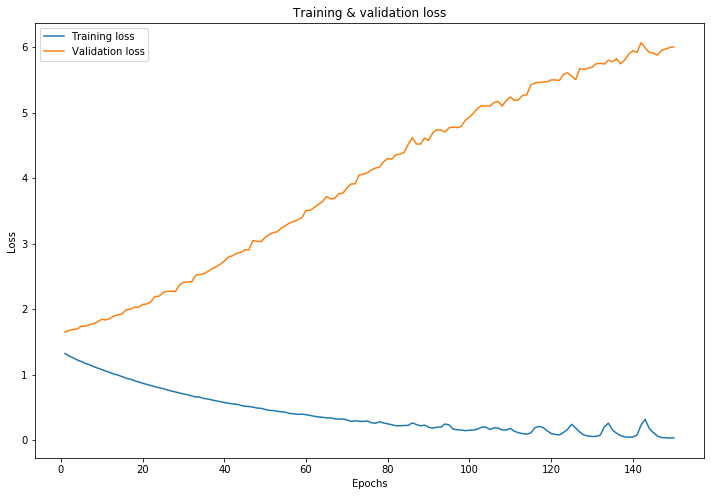

In [268]:
fig, ax = plt.subplots(figsize=(12, 8))

loss_values = baseline_model_val_dict['loss']
val_loss_values = baseline_model_val_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
ax.plot(epochs, loss_values, label='Training loss')
ax.plot(epochs, val_loss_values, label='Validation loss')

ax.set_title('Training & validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

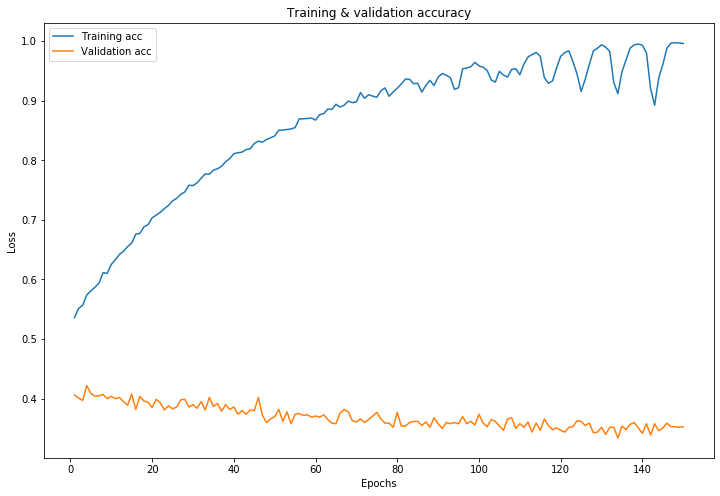

In [269]:
fig, ax = plt.subplots(figsize=(12, 8))

acc_values = baseline_model_val_dict['acc'] 
val_acc_values = baseline_model_val_dict['val_acc']

ax.plot(epochs, acc_values, label='Training acc')
ax.plot(epochs, val_acc_values, label='Validation acc')
ax.set_title('Training & validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

# Early Stopping

In [270]:
from keras import models
from keras import layers
baseline_model = models.Sequential()
baseline_model.add(layers.Dense(64, activation='relu', input_shape=(20,)))
baseline_model.add(layers.Dense(128, activation='relu'))
baseline_model.add(layers.Dense(8, activation='softmax'))

In [271]:
random.seed(123)
model_2 = models.Sequential()
model_2.add(layers.Dense(64, activation='relu', input_shape=(20,)))
model_2.add(layers.Dense(128, activation='relu'))
model_2.add(layers.Dense(8, activation='softmax'))

model_2.compile(optimizer='nadam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

In [272]:
# Import EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [273]:
model_2_val = model_2.fit(X_train, 
                          y_train_lb, 
                          epochs=150, 
                          callbacks=early_stopping ,
                         validation_data=(X_val,y_val_lb))

Train on 5997 samples, validate on 1000 samples
Epoch 1/150
5997/5997 [==============================] - 1s 189us/step - loss: 1.7493 - acc: 0.3470 - val_loss: 1.6980 - val_acc: 0.3800
Epoch 2/150
5997/5997 [==============================] - 0s 42us/step - loss: 1.6170 - acc: 0.4117 - val_loss: 1.6779 - val_acc: 0.3890
Epoch 3/150
5997/5997 [==============================] - 0s 43us/step - loss: 1.5662 - acc: 0.4324 - val_loss: 1.6695 - val_acc: 0.4050
Epoch 4/150
5997/5997 [==============================] - 0s 44us/step - loss: 1.5357 - acc: 0.4449 - val_loss: 1.6471 - val_acc: 0.4030
Epoch 5/150
5997/5997 [==============================] - 0s 43us/step - loss: 1.5023 - acc: 0.4544 - val_loss: 1.6449 - val_acc: 0.4040
Epoch 6/150
5997/5997 [==============================] - 0s 43us/step - loss: 1.4697 - acc: 0.4761 - val_loss: 1.6457 - val_acc: 0.4000
Epoch 7/150
5997/5997 [==============================] - 0s 43us/step - loss: 1.4402 - acc: 0.4886 - val_loss: 1.6258 - val_acc: 0.4260

In [274]:
# Load the best (saved) model
from keras.models import load_model
saved_model = load_model('best_model.h5')

In [275]:
results_train = saved_model.evaluate(X_train, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model.evaluate(X_test, y_test_lb)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

5997/5997 [==============================] - 0s 73us/step
Training Loss: 1.38 
Training Accuracy: 0.51
----------
1000/1000 [==============================] - 0s 20us/step
Test Loss: 1.6 
Test Accuracy: 0.431


In [277]:
# Import regularizers
from keras import regularizers
random.seed(123)
L2_model = models.Sequential()

# Add the input and first hidden layer
L2_model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005), input_shape=(20,)))

# Add another hidden layer
L2_model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.005), activation='relu'))

# Add an output layer
L2_model.add(layers.Dense(8, activation='softmax'))

# Compile the model
L2_model.compile(optimizer='nadam', 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

# Train the model 
L2_model_val = L2_model.fit(X_train, 
                            y_train_lb, 
                            epochs=150,  
                            validation_data=(X_val,y_val_lb))

Train on 5997 samples, validate on 1000 samples
Epoch 1/150
5997/5997 [==============================] - 1s 207us/step - loss: 2.1277 - acc: 0.3558 - val_loss: 1.9457 - val_acc: 0.3930
Epoch 2/150
5997/5997 [==============================] - 0s 45us/step - loss: 1.8353 - acc: 0.3939 - val_loss: 1.8177 - val_acc: 0.4080
Epoch 3/150
5997/5997 [==============================] - 0s 47us/step - loss: 1.7481 - acc: 0.4075 - val_loss: 1.7852 - val_acc: 0.4030
Epoch 4/150
5997/5997 [==============================] - 0s 48us/step - loss: 1.7185 - acc: 0.4094 - val_loss: 1.7496 - val_acc: 0.3770
Epoch 5/150
5997/5997 [==============================] - 0s 53us/step - loss: 1.6958 - acc: 0.4140 - val_loss: 1.7424 - val_acc: 0.3880
Epoch 6/150
5997/5997 [==============================] - 0s 50us/step - loss: 1.6852 - acc: 0.4125 - val_loss: 1.7480 - val_acc: 0.3790
Epoch 7/150
5997/5997 [==============================] - 0s 51us/step - loss: 1.6733 - acc: 0.4140 - val_loss: 1.7376 - val_acc: 0.4000

5997/5997 [==============================] - 0s 46us/step - loss: 1.5057 - acc: 0.5144 - val_loss: 1.7741 - val_acc: 0.4000
Epoch 61/150
5997/5997 [==============================] - 0s 46us/step - loss: 1.4983 - acc: 0.5189 - val_loss: 1.7561 - val_acc: 0.4130
Epoch 62/150
5997/5997 [==============================] - 0s 45us/step - loss: 1.4965 - acc: 0.5218 - val_loss: 1.7959 - val_acc: 0.3940
Epoch 63/150
5997/5997 [==============================] - 0s 49us/step - loss: 1.4993 - acc: 0.5221 - val_loss: 1.7693 - val_acc: 0.4020
Epoch 64/150
5997/5997 [==============================] - 0s 45us/step - loss: 1.4982 - acc: 0.5224 - val_loss: 1.7777 - val_acc: 0.4010
Epoch 65/150
5997/5997 [==============================] - 0s 49us/step - loss: 1.4922 - acc: 0.5268 - val_loss: 1.7925 - val_acc: 0.4100
Epoch 66/150
5997/5997 [==============================] - 0s 45us/step - loss: 1.4966 - acc: 0.5228 - val_loss: 1.7852 - val_acc: 0.4000
Epoch 67/150
5997/5997 [==============================

Epoch 120/150
5997/5997 [==============================] - 0s 45us/step - loss: 1.3962 - acc: 0.5721 - val_loss: 1.9272 - val_acc: 0.3970
Epoch 121/150
5997/5997 [==============================] - 0s 46us/step - loss: 1.3954 - acc: 0.5868 - val_loss: 1.9207 - val_acc: 0.3910
Epoch 122/150
5997/5997 [==============================] - 0s 46us/step - loss: 1.3901 - acc: 0.5813 - val_loss: 1.9251 - val_acc: 0.4140
Epoch 123/150
5997/5997 [==============================] - 0s 46us/step - loss: 1.3900 - acc: 0.5846 - val_loss: 1.9490 - val_acc: 0.3720
Epoch 124/150
5997/5997 [==============================] - 0s 46us/step - loss: 1.3832 - acc: 0.5806 - val_loss: 1.9261 - val_acc: 0.3980
Epoch 125/150
5997/5997 [==============================] - 0s 48us/step - loss: 1.3883 - acc: 0.5798 - val_loss: 1.9291 - val_acc: 0.3990
Epoch 126/150
5997/5997 [==============================] - 0s 46us/step - loss: 1.3814 - acc: 0.5855 - val_loss: 1.9659 - val_acc: 0.4150
Epoch 127/150
5997/5997 [=========

In [278]:
results_train = L2_model.evaluate(X_train, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = L2_model.evaluate(X_test, y_test_lb)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

5997/5997 [==============================] - 0s 25us/step
Training Loss: 1.29 
Training Accuracy: 0.636
----------
1000/1000 [==============================] - 0s 24us/step
Test Loss: 1.93 
Test Accuracy: 0.429


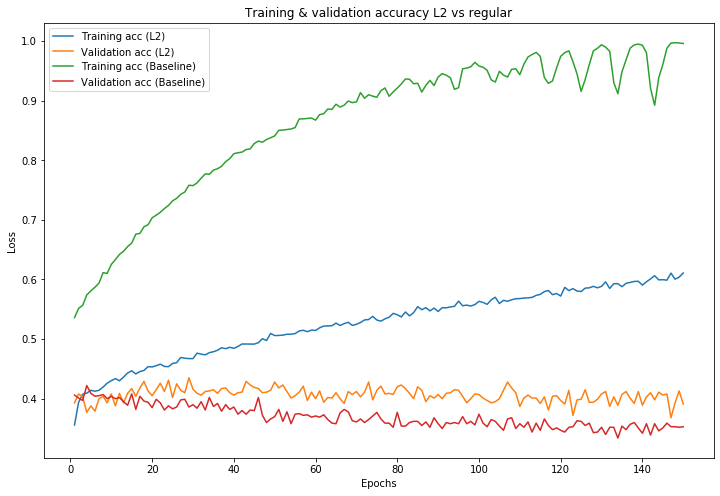

In [279]:
# L2 model details
L2_model_dict = L2_model_val.history
L2_acc_values = L2_model_dict['acc'] 
L2_val_acc_values = L2_model_dict['val_acc']

# Baseline model
baseline_model_acc = baseline_model_val_dict['acc'] 
baseline_model_val_acc = baseline_model_val_dict['val_acc']

# Plot the accuracy for these models
fig, ax = plt.subplots(figsize=(12, 8))
epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, L2_acc_values, label='Training acc (L2)')
ax.plot(epochs, L2_val_acc_values, label='Validation acc (L2)')
ax.plot(epochs, baseline_model_acc, label='Training acc (Baseline)')
ax.plot(epochs, baseline_model_val_acc, label='Validation acc (Baseline)')
ax.set_title('Training & validation accuracy L2 vs regular')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

In [280]:
random.seed(123)
L1_model = models.Sequential()

# Add the input and first hidden layer
L1_model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.005), input_shape=(20,)))

# Add a hidden layer
L1_model.add(layers.Dense(128, kernel_regularizer=regularizers.l1(0.005), activation='relu'))

# Add an output layer
L1_model.add(layers.Dense(8, activation='softmax'))

# Compile the model
L1_model.compile(optimizer='nadam', 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

# Train the model 
L1_model_val = L1_model.fit(X_train, 
                            y_train_lb, 
                            epochs=150, 
                            validation_data=(X_val,y_val_lb))

Train on 5997 samples, validate on 1000 samples
Epoch 1/150
5997/5997 [==============================] - 1s 209us/step - loss: 3.4069 - acc: 0.3288 - val_loss: 2.1840 - val_acc: 0.3220
Epoch 2/150
5997/5997 [==============================] - 0s 46us/step - loss: 2.0054 - acc: 0.3542 - val_loss: 1.9498 - val_acc: 0.3520
Epoch 3/150
5997/5997 [==============================] - 0s 47us/step - loss: 1.9085 - acc: 0.3682 - val_loss: 1.9140 - val_acc: 0.3560
Epoch 4/150
5997/5997 [==============================] - 0s 46us/step - loss: 1.8782 - acc: 0.3717 - val_loss: 1.8870 - val_acc: 0.3520
Epoch 5/150
5997/5997 [==============================] - 0s 46us/step - loss: 1.8562 - acc: 0.3712 - val_loss: 1.8763 - val_acc: 0.3480
Epoch 6/150
5997/5997 [==============================] - 0s 46us/step - loss: 1.8384 - acc: 0.3785 - val_loss: 1.8602 - val_acc: 0.3410
Epoch 7/150
5997/5997 [==============================] - 0s 46us/step - loss: 1.8253 - acc: 0.3714 - val_loss: 1.8497 - val_acc: 0.3540

5997/5997 [==============================] - 0s 45us/step - loss: 1.7259 - acc: 0.4027 - val_loss: 1.7572 - val_acc: 0.3790
Epoch 61/150
5997/5997 [==============================] - 0s 46us/step - loss: 1.7247 - acc: 0.4017 - val_loss: 1.7643 - val_acc: 0.3620
Epoch 62/150
5997/5997 [==============================] - 0s 47us/step - loss: 1.7274 - acc: 0.4019 - val_loss: 1.7631 - val_acc: 0.3820
Epoch 63/150
5997/5997 [==============================] - 0s 47us/step - loss: 1.7248 - acc: 0.4010 - val_loss: 1.7595 - val_acc: 0.3700
Epoch 64/150
5997/5997 [==============================] - 0s 45us/step - loss: 1.7230 - acc: 0.4012 - val_loss: 1.7549 - val_acc: 0.3780
Epoch 65/150
5997/5997 [==============================] - 0s 47us/step - loss: 1.7242 - acc: 0.4062 - val_loss: 1.7655 - val_acc: 0.3850
Epoch 66/150
5997/5997 [==============================] - 0s 47us/step - loss: 1.7248 - acc: 0.4055 - val_loss: 1.7558 - val_acc: 0.3660
Epoch 67/150
5997/5997 [==============================

Epoch 120/150
5997/5997 [==============================] - 0s 46us/step - loss: 1.7057 - acc: 0.4054 - val_loss: 1.7431 - val_acc: 0.3810
Epoch 121/150
5997/5997 [==============================] - 0s 47us/step - loss: 1.7068 - acc: 0.4075 - val_loss: 1.7529 - val_acc: 0.3650
Epoch 122/150
5997/5997 [==============================] - 0s 47us/step - loss: 1.7067 - acc: 0.4047 - val_loss: 1.7451 - val_acc: 0.3940
Epoch 123/150
5997/5997 [==============================] - 0s 49us/step - loss: 1.7062 - acc: 0.4069 - val_loss: 1.7419 - val_acc: 0.3870
Epoch 124/150
5997/5997 [==============================] - 0s 46us/step - loss: 1.7060 - acc: 0.4097 - val_loss: 1.7465 - val_acc: 0.3850
Epoch 125/150
5997/5997 [==============================] - 0s 46us/step - loss: 1.7065 - acc: 0.4070 - val_loss: 1.7436 - val_acc: 0.3860
Epoch 126/150
5997/5997 [==============================] - 0s 46us/step - loss: 1.7055 - acc: 0.4069 - val_loss: 1.7370 - val_acc: 0.3870
Epoch 127/150
5997/5997 [=========

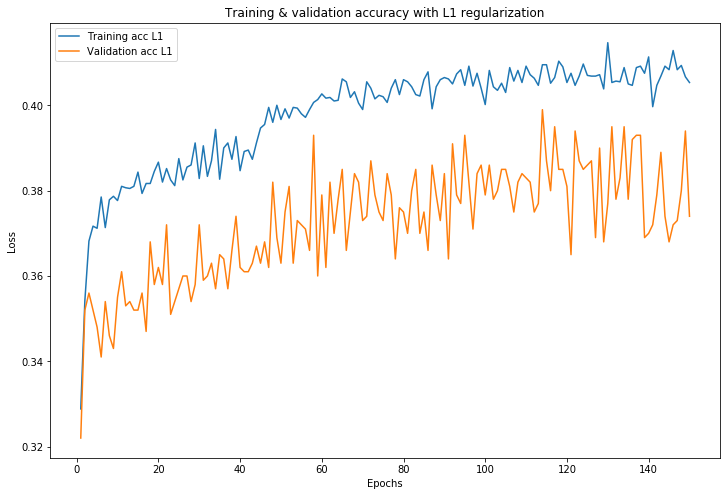

In [281]:
fig, ax = plt.subplots(figsize=(12, 8))

L1_model_dict = L1_model_val.history

acc_values = L1_model_dict['acc'] 
val_acc_values = L1_model_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc L1')
ax.plot(epochs, val_acc_values, label='Validation acc L1')
ax.set_title('Training & validation accuracy with L1 regularization')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

In [282]:
results_train = L1_model.evaluate(X_train, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = L1_model.evaluate(X_test, y_test_lb)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

5997/5997 [==============================] - 0s 25us/step
Training Loss: 1.69 
Training Accuracy: 0.412
----------
1000/1000 [==============================] - 0s 20us/step
Test Loss: 1.72 
Test Accuracy: 0.398


In [283]:
dropout_model = models.Sequential()

# Implement dropout to the input layer
# NOTE: This is where you define the number of units in the input layer
dropout_model.add(layers.Dropout(0.3, input_shape=(20,)))

# Add the first hidden layer
dropout_model.add(layers.Dense(64, activation='relu'))

# Implement dropout to the first hidden layer 
dropout_model.add(layers.Dropout(0.3))

# Add the second hidden layer
dropout_model.add(layers.Dense(128, activation='relu'))

# Implement dropout to the second hidden layer 
dropout_model.add(layers.Dropout(0.3))

# Add the output layer
dropout_model.add(layers.Dense(8, activation='softmax'))


# Compile the model
dropout_model.compile(optimizer='nadam', 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

# Train the model
dropout_model_val = dropout_model.fit(X_train, 
                                      y_train_lb, 
                                      epochs=150, 
                                      validation_data=(X_val, y_val_lb))

Train on 5997 samples, validate on 1000 samples
Epoch 1/150
5997/5997 [==============================] - 1s 227us/step - loss: 1.9366 - acc: 0.2535 - val_loss: 1.7817 - val_acc: 0.3370
Epoch 2/150
5997/5997 [==============================] - 0s 51us/step - loss: 1.8277 - acc: 0.3090 - val_loss: 1.7339 - val_acc: 0.3760
Epoch 3/150
5997/5997 [==============================] - 0s 50us/step - loss: 1.8039 - acc: 0.3245 - val_loss: 1.7234 - val_acc: 0.3860
Epoch 4/150
5997/5997 [==============================] - 0s 50us/step - loss: 1.7968 - acc: 0.3360 - val_loss: 1.7150 - val_acc: 0.3920
Epoch 5/150
5997/5997 [==============================] - 0s 52us/step - loss: 1.7820 - acc: 0.3322 - val_loss: 1.7157 - val_acc: 0.3770
Epoch 6/150
5997/5997 [==============================] - 0s 51us/step - loss: 1.7549 - acc: 0.3478 - val_loss: 1.7039 - val_acc: 0.3860
Epoch 7/150
5997/5997 [==============================] - 0s 55us/step - loss: 1.7593 - acc: 0.3410 - val_loss: 1.6943 - val_acc: 0.3890

5997/5997 [==============================] - 0s 49us/step - loss: 1.6916 - acc: 0.3670 - val_loss: 1.6566 - val_acc: 0.3920
Epoch 61/150
5997/5997 [==============================] - 0s 51us/step - loss: 1.6961 - acc: 0.3762 - val_loss: 1.6608 - val_acc: 0.3920
Epoch 62/150
5997/5997 [==============================] - 0s 49us/step - loss: 1.7079 - acc: 0.3567 - val_loss: 1.6619 - val_acc: 0.3880
Epoch 63/150
5997/5997 [==============================] - 0s 50us/step - loss: 1.6935 - acc: 0.3697 - val_loss: 1.6636 - val_acc: 0.3920
Epoch 64/150
5997/5997 [==============================] - 0s 50us/step - loss: 1.7057 - acc: 0.3670 - val_loss: 1.6736 - val_acc: 0.3860
Epoch 65/150
5997/5997 [==============================] - 0s 49us/step - loss: 1.6958 - acc: 0.3685 - val_loss: 1.6611 - val_acc: 0.3900
Epoch 66/150
5997/5997 [==============================] - 0s 50us/step - loss: 1.6862 - acc: 0.3774 - val_loss: 1.6498 - val_acc: 0.4040
Epoch 67/150
5997/5997 [==============================

Epoch 120/150
5997/5997 [==============================] - 0s 51us/step - loss: 1.6897 - acc: 0.3727 - val_loss: 1.6503 - val_acc: 0.3960
Epoch 121/150
5997/5997 [==============================] - 0s 50us/step - loss: 1.6906 - acc: 0.3739 - val_loss: 1.6569 - val_acc: 0.4120
Epoch 122/150
5997/5997 [==============================] - 0s 51us/step - loss: 1.6809 - acc: 0.3772 - val_loss: 1.6455 - val_acc: 0.4050
Epoch 123/150
5997/5997 [==============================] - 0s 51us/step - loss: 1.6779 - acc: 0.3799 - val_loss: 1.6376 - val_acc: 0.4130
Epoch 124/150
5997/5997 [==============================] - 0s 52us/step - loss: 1.6874 - acc: 0.3752 - val_loss: 1.6440 - val_acc: 0.4060
Epoch 125/150
5997/5997 [==============================] - 0s 50us/step - loss: 1.6808 - acc: 0.3729 - val_loss: 1.6579 - val_acc: 0.3850
Epoch 126/150
5997/5997 [==============================] - 0s 51us/step - loss: 1.6817 - acc: 0.3764 - val_loss: 1.6461 - val_acc: 0.4020
Epoch 127/150
5997/5997 [=========

In [284]:
results_train = dropout_model.evaluate(X_train, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = dropout_model.evaluate(X_test, y_test_lb)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}') 

5997/5997 [==============================] - 0s 27us/step
Training Loss: 1.52 
Training Accuracy: 0.465
----------
1000/1000 [==============================] - 0s 25us/step
Test Loss: 1.61 
Test Accuracy: 0.415


In [288]:
he_model = Sequential()

# Add the first hidden layer
he_model.add(layers.Dense(64, kernel_initializer='he_normal', activation='relu', input_shape=(20,)))

# Add another hidden layer
he_model.add(layers.Dense(128, activation='relu'))

# Add an output layer
he_model.add(layers.Dense(8, activation='linear'))

# Compile the model
he_model.compile(optimizer='nadam', 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

# Train the model
he_model.fit(X_train,  y_train_lb, 
            epochs=150, validation_data=(X_val, y_val_lb))

Train on 5997 samples, validate on 1000 samples
Epoch 1/150
5997/5997 [==============================] - 1s 228us/step - loss: 7.6284 - acc: 0.1659 - val_loss: 8.7456 - val_acc: 0.1520
Epoch 2/150
5997/5997 [==============================] - 0s 45us/step - loss: 8.2737 - acc: 0.1311 - val_loss: 8.3749 - val_acc: 0.1260
Epoch 3/150
5997/5997 [==============================] - 0s 45us/step - loss: 7.7615 - acc: 0.1352 - val_loss: 7.8405 - val_acc: 0.1330
Epoch 4/150
5997/5997 [==============================] - 0s 45us/step - loss: 8.1579 - acc: 0.1552 - val_loss: 8.0117 - val_acc: 0.1630
Epoch 5/150
5997/5997 [==============================] - 0s 46us/step - loss: 8.2619 - acc: 0.1587 - val_loss: 9.1259 - val_acc: 0.1420
Epoch 6/150
5997/5997 [==============================] - 0s 46us/step - loss: 8.2011 - acc: 0.1449 - val_loss: 7.3543 - val_acc: 0.1460
Epoch 7/150
5997/5997 [==============================] - 0s 46us/step - loss: 7.8650 - acc: 0.1369 - val_loss: 7.6024 - val_acc: 0.1390

5997/5997 [==============================] - 0s 44us/step - loss: 8.4367 - acc: 0.1796 - val_loss: 8.1396 - val_acc: 0.1910
Epoch 61/150
5997/5997 [==============================] - 0s 43us/step - loss: 8.4367 - acc: 0.1796 - val_loss: 8.1396 - val_acc: 0.1910
Epoch 62/150
5997/5997 [==============================] - 0s 43us/step - loss: 8.4367 - acc: 0.1796 - val_loss: 8.1396 - val_acc: 0.1910
Epoch 63/150
5997/5997 [==============================] - 0s 43us/step - loss: 8.4367 - acc: 0.1796 - val_loss: 8.1396 - val_acc: 0.1910
Epoch 64/150
5997/5997 [==============================] - 0s 44us/step - loss: 8.4367 - acc: 0.1796 - val_loss: 8.1396 - val_acc: 0.1910
Epoch 65/150
5997/5997 [==============================] - 0s 43us/step - loss: 8.4367 - acc: 0.1796 - val_loss: 8.1396 - val_acc: 0.1910
Epoch 66/150
5997/5997 [==============================] - 0s 45us/step - loss: 8.4367 - acc: 0.1796 - val_loss: 8.1396 - val_acc: 0.1910
Epoch 67/150
5997/5997 [==============================

Epoch 120/150
5997/5997 [==============================] - 0s 46us/step - loss: 8.4367 - acc: 0.1796 - val_loss: 8.1396 - val_acc: 0.1910
Epoch 121/150
5997/5997 [==============================] - 0s 46us/step - loss: 8.4367 - acc: 0.1796 - val_loss: 8.1396 - val_acc: 0.1910
Epoch 122/150
5997/5997 [==============================] - 0s 45us/step - loss: 8.4367 - acc: 0.1796 - val_loss: 8.1396 - val_acc: 0.1910
Epoch 123/150
5997/5997 [==============================] - 0s 46us/step - loss: 8.4367 - acc: 0.1796 - val_loss: 8.1396 - val_acc: 0.1910
Epoch 124/150
5997/5997 [==============================] - 0s 50us/step - loss: 8.4367 - acc: 0.1796 - val_loss: 8.1396 - val_acc: 0.1910
Epoch 125/150
5997/5997 [==============================] - 0s 50us/step - loss: 8.4367 - acc: 0.1796 - val_loss: 8.1396 - val_acc: 0.1910
Epoch 126/150
5997/5997 [==============================] - 0s 48us/step - loss: 8.4367 - acc: 0.1796 - val_loss: 8.1396 - val_acc: 0.1910
Epoch 127/150
5997/5997 [=========

In [290]:
np.random.seed(123)
lecun_model = Sequential()

# Add the first hidden layer
lecun_model.add(layers.Dense(64, kernel_initializer='lecun_normal', activation='relu', input_shape=(20,)))

# Add another hidden layer
lecun_model.add(layers.Dense(128, activation='relu'))

# Add an output layer
lecun_model.add(layers.Dense(8, activation='softmax'))

# Compile the model
lecun_model.compile(optimizer='nadam', 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

# Train the model
lecun_model.fit(X_train,  y_train_lb, 
            epochs=150, validation_data=(X_val, y_val_lb))

Train on 5997 samples, validate on 1000 samples
Epoch 1/150
5997/5997 [==============================] - 1s 241us/step - loss: 1.7593 - acc: 0.3437 - val_loss: 1.7268 - val_acc: 0.3750
Epoch 2/150
5997/5997 [==============================] - 0s 47us/step - loss: 1.6163 - acc: 0.4184 - val_loss: 1.6849 - val_acc: 0.3830
Epoch 3/150
5997/5997 [==============================] - 0s 47us/step - loss: 1.5621 - acc: 0.4337 - val_loss: 1.6414 - val_acc: 0.4000
Epoch 4/150
5997/5997 [==============================] - 0s 48us/step - loss: 1.5198 - acc: 0.4491 - val_loss: 1.6494 - val_acc: 0.4110
Epoch 5/150
5997/5997 [==============================] - 0s 47us/step - loss: 1.4806 - acc: 0.4629 - val_loss: 1.6269 - val_acc: 0.4350
Epoch 6/150
5997/5997 [==============================] - 0s 47us/step - loss: 1.4423 - acc: 0.4812 - val_loss: 1.6460 - val_acc: 0.4230
Epoch 7/150
5997/5997 [==============================] - 0s 47us/step - loss: 1.4080 - acc: 0.4906 - val_loss: 1.6615 - val_acc: 0.4070

5997/5997 [==============================] - 0s 45us/step - loss: 0.4406 - acc: 0.8524 - val_loss: 3.2700 - val_acc: 0.3690
Epoch 61/150
5997/5997 [==============================] - 0s 44us/step - loss: 0.4280 - acc: 0.8564 - val_loss: 3.3122 - val_acc: 0.3600
Epoch 62/150
5997/5997 [==============================] - 0s 45us/step - loss: 0.4237 - acc: 0.8603 - val_loss: 3.3187 - val_acc: 0.3650
Epoch 63/150
5997/5997 [==============================] - 0s 44us/step - loss: 0.4076 - acc: 0.8671 - val_loss: 3.4060 - val_acc: 0.3650
Epoch 64/150
5997/5997 [==============================] - 0s 49us/step - loss: 0.4022 - acc: 0.8684 - val_loss: 3.3802 - val_acc: 0.3650
Epoch 65/150
5997/5997 [==============================] - 0s 45us/step - loss: 0.3895 - acc: 0.8773 - val_loss: 3.5073 - val_acc: 0.3560
Epoch 66/150
5997/5997 [==============================] - 0s 46us/step - loss: 0.3816 - acc: 0.8779 - val_loss: 3.5342 - val_acc: 0.3550
Epoch 67/150
5997/5997 [==============================

Epoch 120/150
5997/5997 [==============================] - 0s 50us/step - loss: 0.1272 - acc: 0.9675 - val_loss: 5.4524 - val_acc: 0.3500
Epoch 121/150
5997/5997 [==============================] - 0s 47us/step - loss: 0.1027 - acc: 0.9768 - val_loss: 5.4731 - val_acc: 0.3570
Epoch 122/150
5997/5997 [==============================] - 0s 46us/step - loss: 0.1169 - acc: 0.9718 - val_loss: 5.5295 - val_acc: 0.3450
Epoch 123/150
5997/5997 [==============================] - 0s 46us/step - loss: 0.1344 - acc: 0.9628 - val_loss: 5.6244 - val_acc: 0.3280
Epoch 124/150
5997/5997 [==============================] - 0s 46us/step - loss: 0.1697 - acc: 0.9501 - val_loss: 5.6483 - val_acc: 0.3380
Epoch 125/150
5997/5997 [==============================] - 0s 46us/step - loss: 0.1750 - acc: 0.9408 - val_loss: 5.6696 - val_acc: 0.3610
Epoch 126/150
5997/5997 [==============================] - 0s 46us/step - loss: 0.1399 - acc: 0.9581 - val_loss: 5.7408 - val_acc: 0.3460
Epoch 127/150
5997/5997 [=========

In [291]:
lecun_model.evaluate(X_train, y_train_lb),lecun_model.evaluate(X_test, y_test_lb)

1000/1000 [==============================] - 0s 23us/step


([0.04581304584105392, 0.9928297482074371], [6.213901206970215, 0.357])

In [292]:
np.random.seed(123)
lecun_model = Sequential()

# Add the first hidden layer
lecun_model.add(layers.Dense(64, kernel_initializer='lecun_normal', activation='relu', input_shape=(20,)))

# Add another hidden layer
lecun_model.add(layers.Dense(128,kernel_regularizer=regularizers.l2(0.005), activation='relu'))

# Add an output layer
lecun_model.add(layers.Dense(8, activation='softmax'))

# Compile the model
lecun_model.compile(optimizer='nadam', 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

# Train the model
lecun_model.fit(X_train,  y_train_lb, 
            epochs=150, validation_data=(X_val, y_val_lb))

Train on 5997 samples, validate on 1000 samples
Epoch 1/150
5997/5997 [==============================] - 1s 242us/step - loss: 2.0480 - acc: 0.3412 - val_loss: 1.9233 - val_acc: 0.3710
Epoch 2/150
5997/5997 [==============================] - 0s 47us/step - loss: 1.7784 - acc: 0.4082 - val_loss: 1.8127 - val_acc: 0.3670
Epoch 3/150
5997/5997 [==============================] - 0s 47us/step - loss: 1.6959 - acc: 0.4189 - val_loss: 1.7287 - val_acc: 0.3920
Epoch 4/150
5997/5997 [==============================] - 0s 47us/step - loss: 1.6537 - acc: 0.4272 - val_loss: 1.7217 - val_acc: 0.4150
Epoch 5/150
5997/5997 [==============================] - 0s 47us/step - loss: 1.6241 - acc: 0.4347 - val_loss: 1.6889 - val_acc: 0.4230
Epoch 6/150
5997/5997 [==============================] - 0s 47us/step - loss: 1.6043 - acc: 0.4406 - val_loss: 1.7080 - val_acc: 0.4070
Epoch 7/150
5997/5997 [==============================] - 0s 48us/step - loss: 1.5864 - acc: 0.4512 - val_loss: 1.7276 - val_acc: 0.4190

5997/5997 [==============================] - 0s 51us/step - loss: 1.1701 - acc: 0.6518 - val_loss: 2.0611 - val_acc: 0.4150
Epoch 61/150
5997/5997 [==============================] - 0s 52us/step - loss: 1.1585 - acc: 0.6505 - val_loss: 2.0166 - val_acc: 0.4200
Epoch 62/150
5997/5997 [==============================] - 0s 49us/step - loss: 1.1548 - acc: 0.6560 - val_loss: 2.0892 - val_acc: 0.3950
Epoch 63/150
5997/5997 [==============================] - 0s 46us/step - loss: 1.1398 - acc: 0.6647 - val_loss: 2.0911 - val_acc: 0.4070
Epoch 64/150
5997/5997 [==============================] - 0s 47us/step - loss: 1.1470 - acc: 0.6627 - val_loss: 2.0946 - val_acc: 0.4070
Epoch 65/150
5997/5997 [==============================] - 0s 47us/step - loss: 1.1362 - acc: 0.6687 - val_loss: 2.1377 - val_acc: 0.3870
Epoch 66/150
5997/5997 [==============================] - 0s 47us/step - loss: 1.1277 - acc: 0.6730 - val_loss: 2.1244 - val_acc: 0.4070
Epoch 67/150
5997/5997 [==============================

Epoch 120/150
5997/5997 [==============================] - 0s 47us/step - loss: 0.9266 - acc: 0.7569 - val_loss: 2.6595 - val_acc: 0.3890
Epoch 121/150
5997/5997 [==============================] - 0s 46us/step - loss: 0.9129 - acc: 0.7599 - val_loss: 2.7892 - val_acc: 0.3810
Epoch 122/150
5997/5997 [==============================] - 0s 46us/step - loss: 0.9439 - acc: 0.7462 - val_loss: 2.7678 - val_acc: 0.3760
Epoch 123/150
5997/5997 [==============================] - 0s 48us/step - loss: 0.9211 - acc: 0.7614 - val_loss: 2.7947 - val_acc: 0.3740
Epoch 124/150
5997/5997 [==============================] - 0s 47us/step - loss: 0.9152 - acc: 0.7632 - val_loss: 2.8173 - val_acc: 0.3760
Epoch 125/150
5997/5997 [==============================] - 0s 48us/step - loss: 0.9113 - acc: 0.7632 - val_loss: 2.7841 - val_acc: 0.3790
Epoch 126/150
5997/5997 [==============================] - 0s 47us/step - loss: 0.9114 - acc: 0.7662 - val_loss: 2.7571 - val_acc: 0.3750
Epoch 127/150
5997/5997 [=========

In [293]:
lecun_model.evaluate(X_train, y_train_lb),lecun_model.evaluate(X_test, y_test_lb)

1000/1000 [==============================] - 0s 27us/step


([0.79689488872918, 0.8120727030579321], [3.0973510665893556, 0.364])